In [1]:
import os
import sys
import json
import warnings
warnings.filterwarnings("ignore")

# Data & utils
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Saving models
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"     # Disable CUDA GPU detection
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"      # Hide TensorFlow logs

In [3]:
df = pd.read_csv("dataset/sensors_dummy_dataset.csv")
df.head()

,pH,turbidity_NTU,temperature_C,DO_mg_L,conductivity_uS_cm
0,4.189,28.134,40.00,1.152,4746.01
1,7.799,5.021,37.58,4.401,2355.28
2,7.901,11.291,35.94,3.020,1903.22
3,8.130,13.960,29.74,2.682,1533.96
4,3.037,33.202,23.77,1.866,4855.42


In [4]:
"""
TDS Calculation Script (Updated):
This script computes the Total Dissolved Solids (TDS) using both
conductivity and temperature, applying temperature compensation
to normalize conductivity to 25°C before converting to TDS.

Temperature Compensation Formula:
    EC25 = Conductivity_measured / (1 + 0.02 × (Temperature_C − 25))

TDS Conversion Formula:
    TDS (mg/L) = EC25 × 0.7

Reason:
Conductivity increases with temperature (~2% per °C). To obtain
accurate TDS values, conductivity is first normalized to standard
temperature (25°C). This improves precision for real wastewater
and treated-water applications and aligns with industrial practice.

Output:
- Adds a new column 'TDS_mg_L' to the DataFrame
- Saves the updated dataset as 'water_quality_dummy_dataset.csv'
"""

# Temperature compensation (normalize conductivity to 25°C)
df["EC25_uS_cm"] = df["conductivity_uS_cm"] / (1 + 0.02 * (df["temperature_C"] - 25))

# TDS calculation using corrected conductivity
df["TDS_mg_L"] = df["EC25_uS_cm"] * 0.7

# Save updated dataset
df.to_csv("dataset/s_tds_dummy_dataset.csv", index=False)

df.head()

,pH,turbidity_NTU,temperature_C,DO_mg_L,conductivity_uS_cm,EC25_uS_cm,TDS_mg_L
0,4.189,28.134,40.00,1.152,4746.01,3650.776923,2555.543846
1,7.799,5.021,37.58,4.401,2355.28,1881.815276,1317.270694
2,7.901,11.291,35.94,3.020,1903.22,1561.552347,1093.086643
3,8.130,13.960,29.74,2.682,1533.96,1401.132627,980.792839
4,3.037,33.202,23.77,1.866,4855.42,4977.875743,3484.513020


In [5]:
"""
Preprocessing Script:
This script cleans the water-quality dataset by removing rows 
that contain values outside the valid sensor operating ranges.
Sensors:
- pH: 0–14
- Turbidity: 0–300 NTU
- Temperature: -10 to 85°C
- DO: 0–20 mg/L
- Conductivity: 0–20000 µS/cm
- TDS: 0–14000 mg/L

Purpose:
Ensures only physically valid, realistic sensor data is used 
for machine learning model training.
"""

condition = (
    (df["pH"].between(0, 14)) &
    (df["turbidity_NTU"].between(0, 300)) &
    (df["temperature_C"].between(-10, 85)) &
    (df["DO_mg_L"].between(0, 20)) &
    (df["conductivity_uS_cm"].between(0, 20000)) &
    (df["TDS_mg_L"].between(0, 14000))
)

df_clean = df[condition]
df_clean.to_csv("dataset/cleaned_dataset.csv", index=False)
print("Cleaned dataset saved.")

Cleaned dataset saved.


In [6]:
"""
Assign Reuse Suitability Labels to Water-Quality Samples
--------------------------------------------------------

This script loads a water-quality dataset, applies rule-based classification
logic to each sample, and assigns one of four reuse categories:

    1. "not_usable"  
    2. "potable_high_quality_reuse"  
    3. "irrigation"  
    4. "cooling"

Purpose
-------
The objective is to automatically determine the most suitable reuse option for
treated water based on commonly referenced thresholds in wastewater treatment,
industrial reuse guidelines, and general water-quality standards.

Input Dataset Columns
---------------------
The function `assign_reuse_label` expects the following columns in each row:

- pH
- turbidity_NTU
- temperature_C
- DO_mg_L  (Dissolved Oxygen)
- conductivity_uS_cm  (Electrical Conductivity)
- TDS_mg_L

Classification Logic
--------------------

1. NOT USABLE ("not_usable")
   Water is rejected if ANY of the following are true:
   - TDS > 3000 mg/L  
   - Turbidity > 50 NTU  
   - DO < 2 mg/L  
   - pH outside 5.5–9.0  
   - EC > 6000 µS/cm  

2. POTABLE / HIGH-QUALITY REUSE
   Water is considered high quality if ALL of the following are true:
   - Turbidity < 2 NTU  
   - TDS < 500 mg/L  
   - pH between 6.5 and 8.5  
   - DO > 6 mg/L  

3. IRRIGATION
   Suitable for irrigation when ALL conditions below are satisfied:
   - Turbidity < 10 NTU  
   - TDS < 1500 mg/L  
   - DO > 4 mg/L  
   - EC < 2500 µS/cm  

4. COOLING TOWER
   Water qualifies for cooling tower reuse if ALL of these are true:
   - TDS < 3000 mg/L  
   - Turbidity < 50 NTU  
   - DO > 2 mg/L  

If a sample does not satisfy any category except cooling, the fallback label is
"not_usable" to ensure conservative classification.

Output
------
- Adds a new column `reuse_label` to the DataFrame.
- Saves the labeled dataset to: "water_quality_labeled_4_categories.csv"
- Prints category distribution for quick inspection.

Usage
-----
Run this script in an environment where `water_quality_dummy_dataset.csv`
exists. The classification logic can be modified to align with project-specific
regulatory standards or industry requirements.
"""


import pandas as pd

df = pd.read_csv("dataset/cleaned_dataset.csv")

def assign_reuse_label(row):
    pH = row["pH"]
    turb = row["turbidity_NTU"]
    temp = row["temperature_C"]
    DO = row["DO_mg_L"]
    EC = row["conductivity_uS_cm"]
    TDS = row["TDS_mg_L"]

    if (
        TDS > 3000
        or turb > 50
        or DO < 2
        or pH < 5.5 or pH > 9.0
        or EC > 6000
    ):
        return "not_usable"

    if (
        turb < 2
        and TDS < 500
        and 6.5 <= pH <= 8.5
        and DO > 6
    ):
        return "potable_high_quality_reuse"
    if (
        turb < 10
        and TDS < 1500
        and DO > 4
        and EC < 2500
    ):
        return "irrigation"

    if (
        TDS < 3000
        and turb < 50
        and DO > 2
    ):
        return "cooling"

    # Fallback (rare)
    return "not_usable"


df["reuse_label"] = df.apply(assign_reuse_label, axis=1)

df.to_csv("dataset/water_quality_with_labels.csv", index=False)

print("Labels added successfully!")
print(df["reuse_label"].value_counts())


Labels added successfully!
reuse_label
cooling                       977
irrigation                    790
not_usable                    707
potable_high_quality_reuse     26
Name: count, dtype: int64


In [7]:
df = pd.read_csv("dataset/water_quality_with_labels.csv")
df.head()

,pH,turbidity_NTU,temperature_C,DO_mg_L,conductivity_uS_cm,EC25_uS_cm,TDS_mg_L,reuse_label
0,4.189,28.134,40.00,1.152,4746.01,3650.776923,2555.543846,not_usable
1,7.799,5.021,37.58,4.401,2355.28,1881.815276,1317.270694,irrigation
2,7.901,11.291,35.94,3.020,1903.22,1561.552347,1093.086643,cooling
3,8.130,13.960,29.74,2.682,1533.96,1401.132627,980.792839,cooling
4,3.037,33.202,23.77,1.866,4855.42,4977.875743,3484.513020,not_usable


In [8]:
X = df[['pH','turbidity_NTU','temperature_C','DO_mg_L',
        'conductivity_uS_cm','TDS_mg_L']]
y = df['reuse_label']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
classes = list(le.classes_)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(le, "models/label_encoder.joblib")
joblib.dump(scaler, "models/scaler.joblib")

['models/scaler.joblib']

### Train Logistic Regression, Decision Tree, Random Forest

In [10]:
RANDOM_STATE = 42
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=2000, class_weight="balanced")
lr.fit(X_train_scaled, y_train)
joblib.dump(lr, "models/logistic_regression.joblib")

print("Training Decision Tree...")
dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")
dt.fit(X_train, y_train)
joblib.dump(dt, "models/decision_tree.joblib")

print("Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)
joblib.dump(rf, "models/random_forest.joblib")

print("Sklearn models trained successfully.")

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Sklearn models trained successfully.


In [13]:
probs = {}

# LR
probs["logistic"] = lr.predict_proba(X_test_scaled)

# Decision Tree
probs["decision_tree"] = dt.predict_proba(X_test)

# Random Forest
probs["random_forest"] = rf.predict_proba(X_test)

# Convert to predictions
preds = {k: np.argmax(v, axis=1) for k, v in probs.items()}

# Soft ensemble
avg_probs = np.mean(list(probs.values()), axis=0)
preds["ensemble_soft"] = np.argmax(avg_probs, axis=1)

print("All model predictions generated.")

All model predictions generated.


In [14]:
results = []

for model_name, pred in preds.items():
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, average="macro", zero_division=0)
    rec = recall_score(y_test, pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, pred, average="macro", zero_division=0)

    results.append({
        "model": model_name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1
    })

results_df = pd.DataFrame(results).sort_values("f1_macro", ascending=False)
results_df

,model,accuracy,precision_macro,recall_macro,f1_macro
1,decision_tree,0.992,0.994324,0.993903,0.994091
3,ensemble_soft,0.992,0.994324,0.993903,0.994091
2,random_forest,0.990,0.992513,0.847142,0.887663
0,logistic,0.902,0.767140,0.922020,0.783280


In [16]:
eval_csv = "dataset/prediction_evaluation/evaluation_results.csv"
results_df.to_csv(eval_csv, index=False)

preds_df = X_test.reset_index(drop=True)
preds_df["true"] = le.inverse_transform(y_test)
preds_df["logistic"] = le.inverse_transform(preds["logistic"])
preds_df["decision_tree"] = le.inverse_transform(preds["decision_tree"])
preds_df["random_forest"] = le.inverse_transform(preds["random_forest"])
preds_df["ensemble"] = le.inverse_transform(preds["ensemble_soft"])

preds_df.to_csv("dataset/prediction_evaluation/sample_predictions.csv", index=False)

print("Files saved successfully")

Files saved successfully


MODEL: LOGISTIC

Classification Report:
                            precision    recall  f1-score   support

                   cooling       0.88      0.97      0.92       196
                irrigation       0.95      0.80      0.87       158
                not_usable       1.00      0.91      0.96       141
potable_high_quality_reuse       0.24      1.00      0.38         5

                  accuracy                           0.90       500
                 macro avg       0.77      0.92      0.78       500
              weighted avg       0.93      0.90      0.91       500



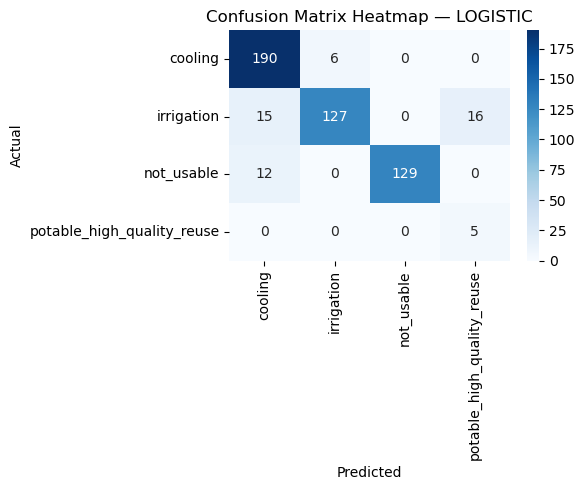

MODEL: DECISION_TREE

Classification Report:
                            precision    recall  f1-score   support

                   cooling       0.99      0.99      0.99       196
                irrigation       0.99      1.00      0.99       158
                not_usable       1.00      0.99      0.99       141
potable_high_quality_reuse       1.00      1.00      1.00         5

                  accuracy                           0.99       500
                 macro avg       0.99      0.99      0.99       500
              weighted avg       0.99      0.99      0.99       500



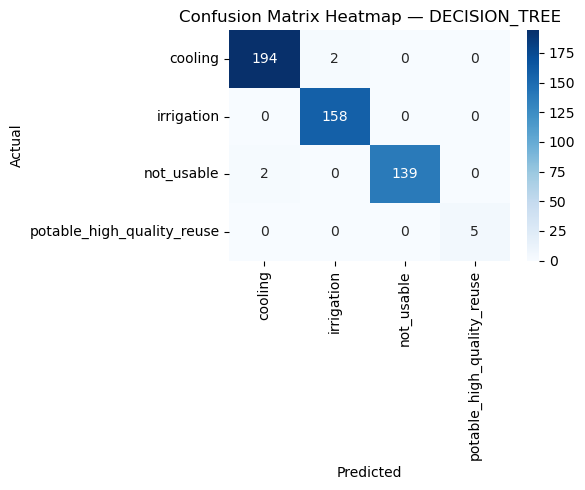

MODEL: RANDOM_FOREST

Classification Report:
                            precision    recall  f1-score   support

                   cooling       0.99      0.99      0.99       196
                irrigation       0.98      0.99      0.98       158
                not_usable       1.00      1.00      1.00       141
potable_high_quality_reuse       1.00      0.40      0.57         5

                  accuracy                           0.99       500
                 macro avg       0.99      0.85      0.89       500
              weighted avg       0.99      0.99      0.99       500



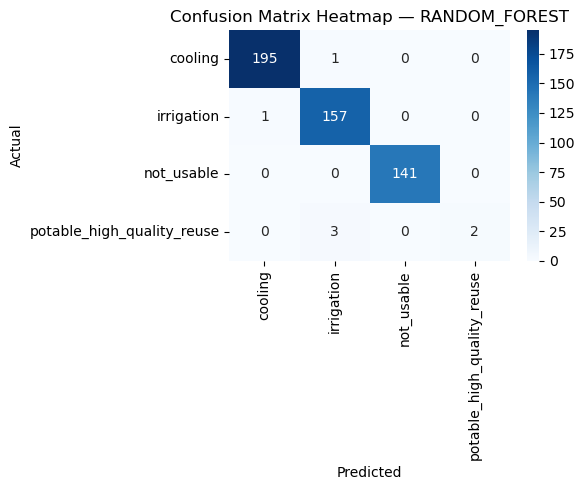

MODEL: ENSEMBLE_SOFT

Classification Report:
                            precision    recall  f1-score   support

                   cooling       0.99      0.99      0.99       196
                irrigation       0.99      1.00      0.99       158
                not_usable       1.00      0.99      0.99       141
potable_high_quality_reuse       1.00      1.00      1.00         5

                  accuracy                           0.99       500
                 macro avg       0.99      0.99      0.99       500
              weighted avg       0.99      0.99      0.99       500



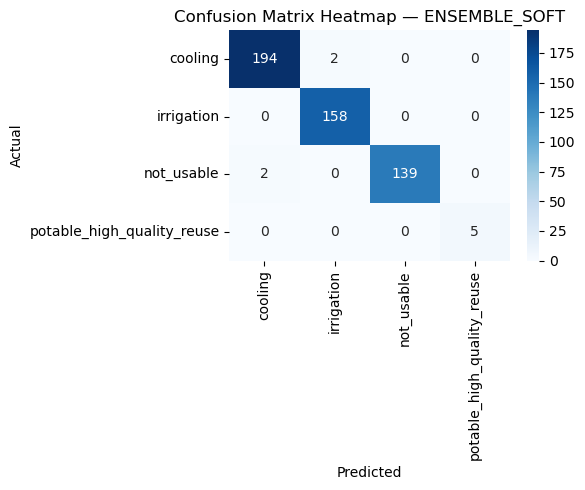

In [18]:
models_to_show = ["logistic", "decision_tree", "random_forest", "ensemble_soft"]

for model_name in models_to_show:
    print("=" * 80)
    print(f"MODEL: {model_name.upper()}")
    print("=" * 80)

    y_true = y_test
    y_pred = preds[model_name]

    # ---- Classification Report ----
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=classes,
        zero_division=0
    ))

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix Heatmap — {model_name.upper()}")
    plt.tight_layout()
    plt.show()
